## CPR Generation Policy autoeval analysis

The aim of this notebook is to analyse the various versions of the g-eval autoevaluator on CPR Generation Policy. 

In [21]:
import json
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from pathlib import Path

sys.path.append(Path(".").absolute().parent.parent.as_posix())

from src.online.data_models import EndToEndGeneration
from src.evaluation.evaluator import Score

In [4]:
g_eval_generations_path = Path("../../data/eval/autoeval_results/results_filtered_by_retrieval_length_g_eval_binary_200_start_100.jsonl")

In [12]:
def true_and_pred_format(df: pd.DataFrame, human: list[Score], flip_score = True) -> tuple[list[float], list[float]]:
    """Reformats the Score objects and the dataframe into the sklearn format. Flips scores by default"""
    ids = df["gen_uuid"].tolist()

    y_pred = df["score"].tolist()
    y_true = [next(score.score for score in human if score.gen_uuid == gen_uuid) for gen_uuid in ids]

    if flip_score:
        y_pred = [1 if y_pred == 0 else 0 for y_pred in y_pred]
        y_true = [1 if y_true == 0 else 0 for y_true in y_true]

    return y_true, y_pred

In [16]:
def print_scores(y_true: list[float], y_pred: list[float]):
    print(f"F1 score: {round(f1_score(y_true, y_pred), 3)}")
    print(f"Precision: {round(precision_score(y_true, y_pred), 3)}")
    print(f"Recall: {round(recall_score(y_true, y_pred), 3)}")
    print(f"Accuracy: {round(accuracy_score(y_true, y_pred), 3)}")

In [36]:
def merge_datasets(df: pd.DataFrame, human: list[Score]) -> pd.DataFrame:
    merged = pd.concat([df, pd.DataFrame([score.model_dump() for score in human])], axis=0)

    merged = merged.pivot(index="gen_uuid", columns="name", values="score")\
        .dropna(subset=["g_eval"]).reset_index().groupby(["g_eval", "human"])\
        .count()\
        .unstack()

    merged.columns = merged.columns.droplevel(0)

    return merged

In [8]:
with open("../../data/eval/cpr_generation_policy_human_annotation_scores.jsonl", "r") as f:
    human_scores = [Score.model_validate_json(line) for line in f]

human_score_ids = [score.gen_uuid for score in human_scores]

generations = pd.read_json("../../data/final_2_all.jsonl", lines=True)
generations["uuid"] = generations["generation"].apply(lambda x: EndToEndGeneration.model_validate(x).uuid)

cpr_generation_dataset = generations[generations["uuid"].isin(human_score_ids)]

In [38]:
df = pd.read_json(g_eval_generations_path, lines=True)
df.drop_duplicates(subset=["gen_uuid"], inplace=True)

merged = merge_datasets(df, human_scores)

In [39]:
print_scores(
    *true_and_pred_format(df, human_scores)
)

F1 score: 0.354
Precision: 0.292
Recall: 0.452
Accuracy: 0.745


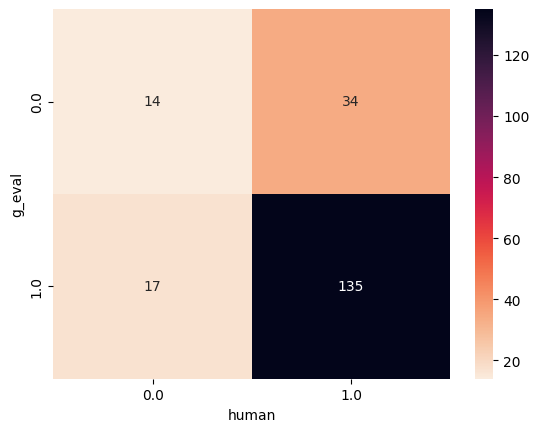

In [40]:
sns.heatmap(merged, annot=True, fmt="d", cmap=sns.cm.rocket_r)
plt.show()

In [25]:
# after looking through all 17 false negatives and 34 false positives, below are the comments
# as to why they were misclassified

false_negative_comments = {
    'ef8f351e7a108a0a344d9c6a2c88ddfb': 'Citation shifted',
    'aec7b4fe0d9c9df807b6735cbf11e095': 'No response case',
    '8dea36738a5ed422dcf97dd733d8ebc6': 'No citation, hallucination (?), couldn’t have been answered — section headers',
    'f22b006a3199318725f52abfc8338ab7': 'Hallucination couldn’t have been answered',
    '2136b555b860a6dd3e9db982fff8e850': 'No response case',
    'ee8a7bf1f71affd912ee640d81f6e843': 'Hallucination (maybe?) — annotator error?',
    'ba00dbec47f21de3cfe1347bbb9c04da': 'Annotator error? Maybe some hallucination detected? Maybe unclear whether “observatory” is “National Observatory on Climate Change”?',
    '9bd32d8907359a741885b43b6d56408d': 'No response case with explanation',
    'd267e4cc5277bec5b527377750e89123': 'Very clear adversarial answer, should be picked up',
    'b0912b1cb7be1d2589c999253f35e9d9': 'unclear?',
    '985777a60afa0225d78e610c074bb181': 'No response (but later response)',
    '90ccc1892096dbfb1e838c49cc6ed07d': 'No response',
    '301e3937390885673ed1a3049545ce15': 'Hallucination (maybe? Unclear whether it’s talking about belarus)',
    '80dbcb350d8818f7cc027884ec04588d': 'Unsupported claim (hallucination? Or the lack of information?)',
    '39f48b78965e20c19c06be22d9c39cbe': 'Citations shifted',
    '523f6620606da36036588c64b1bb0ad4': 'Citations shifted',
    'c882048436962cf8f35e42adf9f60693': 'Tricky no response case “the document only”? '
}

false_positive_comments = {
    'f885b10edcb595484060a69d9f668098': 'No response case',
    '6cb567439c01a4fc4fe4682aff6a8316': 'No response case',
    '7dc6390833e6cb44d567386f0e408a33': 'No response case',
    '70fb542b20e95010d193b1145a16200c': 'Very strong hallucination ',
    'f18431f695ebfa73b8c57fe4960af707': 'No response case',
    'fefb85769e9ba94cbdc6ad6514e97605': 'No response case',
    '7f6e36e93ef21881bd498ea9b8a29286': 'No response case',
    '1288b401c44f4eebe987d704ffd3054f': 'Strong hallucination',
    'd02e73092957dafeac050245f4d7e76f': 'No response case',
    '8db51cea4b5e16deab560a2c57ad9ca1': 'Strong hallucination',
    '8440565f6569fc7e01bc710dedbfc2eb': 'No response case',
    'b523d5159667fe72caa353a31b89c0b6': 'Wrong answer (hallucination)',
    '7bac54baf3ea1f5e42db5ab391f053b5': 'No response case',
    '9cb462ef2adbc07e45b2844fcad98fb4': 'No response case',
    'e29d81315d744a07a194d8f2409155dc': 'Citation shifted, unclear if it’s talking about the right thing',
    'e4b9ac57303f391e2e798248c7c538ac': 'Unclear answer, bad citation (some hallucination)',
    '6f821b139e0b9e48c8131ad470144f63': 'No response case',
    '15a305899d03b190d1d37a1f9bf40f4e': 'No response case',
    '27587d7966b391747f73f3bf8a74cfe3': 'No response case',
    '3f964e1b88d464f837f947bc53b9d46c': 'No response case (but later responds)',
    '70723363d12fbcb6d4e4a319543af924': 'No response case',
    'f66369e9a7776f10581e5b769442a2b4': 'Hallucination',
    '7170f95f5c68eb526bc07acb7535f658': 'No response case',
    '74eff42140cbdb93532c5cc1a66b8b39': 'No response case',
    '327f7d827de85879dc69aadf73e23d3b': 'No response case',
    '9cf008dd3e58ddd7d6fad74b5b52ecb5': 'No response case',
    '74cc104f4e8ef118c820bd54e0a4e340': 'No response case',
    'e9959d99a5cddec58c7826f926bc881e': 'No response case',
    '96c24d3acdfcc5bf3e616e070b1db11c': 'No response case',
    'b406ffd703a7087ed56a6a31fe98d490': 'Hallucination, bad citations',
    'f142ec1ead74e63eb03b4734ffe334f8': 'No response case',
    '67bf4f64cf782e760b76da07ac928fde': 'Bad citations, says the plan doesn’t include something',
    '95a819da0e32ce4be84252be0b12a150': 'Hallucination (contrary to info in context)',
    '478a36c1218eef6d0338bbea2af21b8b': 'No response case'
}

## No response cases filtered, hallucination addressed
Based on the above it seems like a large category issue is the no response cases. For the filtering, refer to:<br>
`notebooks/unece-postprocessing/filtering_cpr_generation_policy_questions.ipynb`

In [53]:
filtered_system_responds_path = Path("../../data/eval/autoeval_results/results_filtered_by_response_and_retrieval_length_g_eval_binary_300_hallucination.jsonl")

In [54]:
df = pd.read_json(filtered_system_responds_path, lines=True)
df.drop_duplicates(subset=["gen_uuid"], inplace=True)

merged = merge_datasets(df, human_scores)

In [55]:
print_scores(
    *true_and_pred_format(df, human_scores)
)

F1 score: 0.366
Precision: 0.3
Recall: 0.469
Accuracy: 0.827


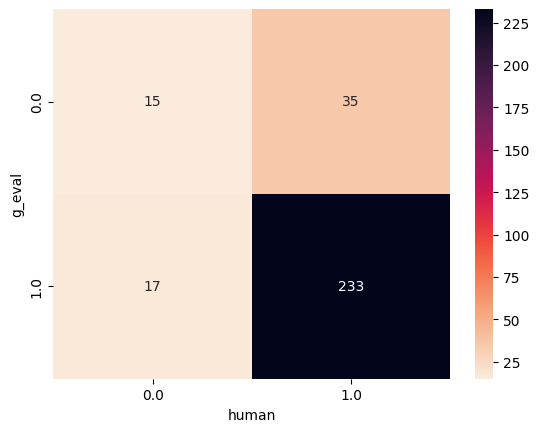

In [56]:
sns.heatmap(merged, annot=True, fmt="d", cmap=sns.cm.rocket_r)
plt.show()